In [3]:
from attention import AttentionLayer

In [4]:
import numpy as np
import pandas as pd 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional, Add
from tensorflow.keras.models import Model
import tensorflow_datasets as tfds
import tensorflow as tf

In [8]:
data = pd.read_csv("Reviews.csv", nrows=1000)

In [9]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [11]:
def text_cleaner(text):
    text = text.lower()
    text = text.replace(".", "")
    text = text.replace("unk", "")
    text = text.replace(" 's", "")
    tokens = text.split()
    tokens = [t for t in tokens if t.isalnum()]
    return (" ".join(tokens)).strip()

In [12]:
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t)) 

cleaned_text[:5]

['i have bought several of the vitality canned dog food products and have found them all to be of good quality the product looks more like a stew than a processed meat and it smells better my labrador is finicky and she appreciates this product better than most',
 'product arrived labeled as jumbo salted peanutsthe peanuts were actually small sized unsalted not sure if this was an error or if the vendor intended to represent the product as',
 'this is a confection that has been around a few centuries it is a pillowy citrus gelatin with nuts in this case filberts and it is cut into tiny squares and then liberally coated with powdered sugar and it is a tiny mouthful of heaven not too and very flavorful i highly recommend this yummy treat if you are familiar with the story of cs the and the this is the treat that seduces edmund into selling out his brother and sisters to the witch',
 'if you are looking for the secret ingredient in robitussin i believe i have found it i got this in additi

In [13]:
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(text_cleaner(t))

cleaned_summary[:5]

['good quality dog food',
 'not as advertised',
 'says it all',
 'cough medicine',
 'great taffy']

In [14]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

In [15]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text,cleaned_summary
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,i have bought several of the vitality canned d...,good quality dog food
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled as jumbo salted peanut...,not as advertised
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,this is a confection that has been around a fe...,says it all
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,if you are looking for the secret ingredient i...,cough medicine
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffy at a great price there was a wide ...,great taffy


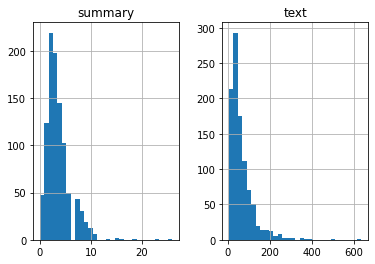

In [16]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [17]:
max_text_len = 90
max_summary_len = 15

In [18]:
df = pd.DataFrame({'text':np.array(data['cleaned_text']), 'summary':np.array(data['cleaned_summary'])})
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [19]:
df.head()

,text,summary
0,i have bought several of the vitality canned d...,sostok good quality dog food eostok
1,product arrived labeled as jumbo salted peanut...,sostok not as advertised eostok
2,this is a confection that has been around a fe...,sostok says it all eostok
3,if you are looking for the secret ingredient i...,sostok cough medicine eostok
4,great taffy at a great price there was a wide ...,sostok great taffy eostok


In [20]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True) 

In [21]:
#prepare a tokenizer for reviews on training data
tokenizer = Tokenizer() 
tokenizer.fit_on_texts(list(x_tr) + list(y_tr))

#convert text sequences into integer sequences
x_tr_seq    =   tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

y_tr_seq    =   tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary ( +1 for padding token)
voc   =  len(tokenizer.word_index) + 1

In [22]:
voc

5258

In [23]:
x_tr.shape

(900, 90)

In [24]:
# Reference: https://stackoverflow.com/questions/50815354/seq2seq-bidirectional-encoder-decoder-in-keras

from keras import backend as K 
K.clear_session() 
latent_dim = x_tr.shape[0]

# Encoder 
encoder_inputs = Input(shape=(max_text_len,)) 
enc_emb = Embedding(voc, latent_dim,trainable=True)(encoder_inputs) 

forward_layer = LSTM(latent_dim, return_sequences=True, return_state=True)
backward_layer = LSTM(latent_dim, return_sequences=True, return_state=True, go_backwards=True)

bidirectional_lstm = Bidirectional(forward_layer, backward_layer=backward_layer)
encoder_outputs, forward_h, forward_c, backward_h, backward_c = bidirectional_lstm(enc_emb)

state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
encoder_states = [state_h, state_c]

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(voc, latent_dim, trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state1 = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(voc, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Using TensorFlow backend.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 90)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 90, 900)      4732200     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 90, 1800), ( 12967200    embedding[0][0]                  
______________________________________________________________________________________________

In [25]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [26]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=30, validation_split=0.2)

Epoch 1/30
23/23 [==============================] - 22s 950ms/step - loss: 3.3136 - val_loss: 2.2493
Epoch 2/30
23/23 [==============================] - 21s 900ms/step - loss: 1.9328 - val_loss: 2.0112
Epoch 3/30
23/23 [==============================] - 21s 898ms/step - loss: 1.6657 - val_loss: 1.9217
Epoch 4/30
23/23 [==============================] - 20s 891ms/step - loss: 1.5906 - val_loss: 1.9602
Epoch 5/30
23/23 [==============================] - 20s 886ms/step - loss: 1.5362 - val_loss: 1.9741
Epoch 6/30
23/23 [==============================] - 21s 892ms/step - loss: 1.4857 - val_loss: 1.9785
Epoch 7/30
23/23 [==============================] - 21s 896ms/step - loss: 1.4284 - val_loss: 2.0123
Epoch 8/30
23/23 [==============================] - 20s 890ms/step - loss: 1.3663 - val_loss: 2.0447
Epoch 9/30
23/23 [==============================] - 21s 893ms/step - loss: 1.3229 - val_loss: 2.1065
Epoch 10/30
23/23 [==============================] - 21s 895ms/step - loss: 1.3352 - val_lo

In [27]:
model.save("Amazon_model_1.h5", save_format="h5")

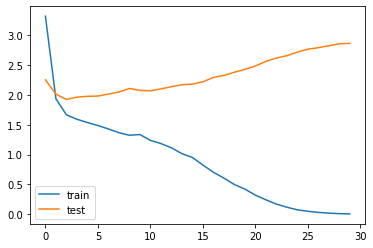

In [28]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [29]:
reverse_word_index=tokenizer.index_word
word_index=tokenizer.word_index

In [30]:
# Reference: https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim*2,))
decoder_state_input_c = Input(shape=(latent_dim*2,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim*2))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [31]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        
        try:
            sampled_token = reverse_word_index[sampled_token_index]
        except KeyError as e:
            sampled_token = 'unk'
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [32]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=word_index['sostok']) and i!=word_index['eostok']):
            try:
                newString=newString+reverse_word_index[i]+' '
            except KeyError:
                newString=newString+'unk '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            try:
                newString=newString+reverse_word_index[i]+' '
            except KeyError:
                newString=newString+'unk '
    return newString

In [33]:
original = []
created = []

for i in range(0,x_val.shape[0]):
    print("Review:",seq2text(x_val[i]))
    print("Original summary:",seq2summary(y_val[i]))
    original.append(str(seq2summary(y_val[i])))

    print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_text_len)))
    created.append(str(decode_sequence(x_val[i].reshape(1,max_text_len))))

    print("\n")

Review: so far i have had the habanero and the medium sauces and they were amazing my fiance and i use them nearly daily and i just picked up 3 more it goes really well on all of dishes to add the extra sauce itself lasts a lot longer than it appears it is thick and a bottle will last us a couple of weeks of heavy use we love to use it for breakfast on eggs or in and for dinners or soups for added spice 
Original summary: best all around hot sauce 
Predicted summary:  excellent taste


Review: of snacks this is a pretty good option it does contain and so if any of these are an issue for then want to pass it also says on the packaging that the manufactured in also processes eggs and peanuts the product use either of but the is nice if particularly sensitive to a great snack at a great price the 10 pack really is 20 of the so quite a few snacks one if you live in a hot order them in the summer because they will melt together 
Original summary: i love this 
Predicted summary:  more price 